In [43]:
import pandas as pd
import numpy as np
import pymc3 as pm
import scipy
np.random.seed(42)
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from scipy.stats import percentileofscore
from scipy import stats
import matplotlib
import seaborn as sns
from IPython.core.pylabtools import figsize
pd.set_option('display.max_columns', 500) #replace n with the number of columns you want to see completely
pd.set_option('display.max_rows', 500)


df = pd.read_csv('C:\python Projects/all_events_final1_fscore_wind.csv') #../input/student-mat.csv
df.head()

,Vmean,Vmax,Bmax,VmBm,MagnM,Bdo_Bup,DV,Ndo_Nup,Thita
0,312,429,17.3,3.71,1.7,1.63,27,1.68,37
1,505,468,15.2,3.56,2.5,2.97,26,2.57,51
2,600,524,25.3,6.63,4.3,2.49,76,2.26,86
3,378,358,11.0,1.97,2.3,1.69,22,1.78,57
4,434,560,17.3,4.84,3.3,1.85,30,1.83,88


In [44]:
df.shape

(146, 9)

In [45]:
df.describe()

,Vmean,Vmax,Bmax,VmBm,MagnM,Bdo_Bup,DV,Ndo_Nup,Thita
count,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000
mean,720.376712,579.253425,19.948630,6.121096,5.003425,2.294863,103.773973,2.403562,58.136986
std,221.954178,141.034054,9.285311,4.253935,3.560597,0.745308,71.131328,0.714846,20.793112
min,312.000000,356.000000,7.200000,1.410000,0.600000,1.300000,21.000000,1.210000,4.000000
25%,573.000000,468.250000,13.925000,3.332500,2.425000,1.755000,52.750000,1.932500,41.000000
50%,657.500000,535.000000,18.050000,5.065000,3.850000,2.135000,86.000000,2.245000,62.000000
75%,851.000000,671.750000,24.100000,7.542500,6.600000,2.625000,131.750000,2.662500,74.750000
max,1384.000000,1059.000000,56.900000,29.590000,16.400000,5.580000,361.000000,5.740000,89.000000


In [46]:
numerical_values = df.select_dtypes(include = ['float64', 'int64']).columns.values
numerical_values

array(['Vmean', 'Vmax', 'Bmax', 'VmBm', 'MagnM', 'Bdo_Bup', 'DV',
       'Ndo_Nup', 'Thita'], dtype=object)

In [47]:
df.corr()['MagnM'].sort_values()

Thita      0.093872
Ndo_Nup    0.258193
Bdo_Bup    0.335826
Vmean      0.642325
DV         0.650885
Bmax       0.702628
Vmax       0.710841
VmBm       0.772384
MagnM      1.000000
Name: MagnM, dtype: float64

In [48]:
df.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)

,Vmean,Vmax,Bmax,VmBm,MagnM,Bdo_Bup,DV,Ndo_Nup,Thita
Vmean,1.000000,0.774938,0.668752,0.846417,0.469022,0.686178,0.667155,0.642363,0.405272
Vmax,0.774938,1.000000,0.687610,0.828687,0.484984,0.672546,0.682664,0.672724,0.372711
Bmax,0.668752,0.687610,1.000000,0.749508,0.558433,0.710582,0.620613,0.604314,0.331782
VmBm,0.846417,0.828687,0.749508,1.000000,0.491255,0.780633,0.725479,0.681569,0.390157
MagnM,0.469022,0.484984,0.558433,0.491255,1.000000,0.470137,0.399673,0.368170,0.211066
Bdo_Bup,0.686178,0.672546,0.710582,0.780633,0.470137,1.000000,0.679072,0.638716,0.305025
DV,0.667155,0.682664,0.620613,0.725479,0.399673,0.679072,1.000000,0.488705,0.277929
Ndo_Nup,0.642363,0.672724,0.604314,0.681569,0.368170,0.638716,0.488705,1.000000,0.298752
Thita,0.405272,0.372711,0.331782,0.390157,0.211066,0.305025,0.277929,0.298752,1.000000


In [49]:
def format_data(df):
    
    labels = df['MagnM']

    df = df.drop(columns=['VmBm', 'Vmax'])
    df = pd.get_dummies(df)
    
    # Find correlations with the MagnM
    most_correlated = df.corr().abs()['MagnM'].sort_values(ascending=False)
    
    # top 5 most correlation features with MagnM
    most_correlated = most_correlated[:7]
    
    df = df.loc[:, most_correlated.index]
    df = df.drop(columns = 'Thita')
    
    #training/testing sets with 25% split
    X_train, X_test, y_train, y_test = train_test_split(df, labels, 
    test_size = 0.25,
    random_state=42)
    
    return X_train, X_test, y_train, y_test

In [50]:
X_train, X_test, y_train, y_test = format_data(df)
X_train.head()

,MagnM,Bmax,DV,Vmean,Bdo_Bup,Ndo_Nup
84,6.5,14.3,162,752,3.68,3.18
68,12.3,56.9,314,1323,5.20,5.60
51,3.2,11.5,138,674,2.30,1.84
135,0.9,13.1,67,666,2.22,2.32
134,3.6,11.2,40,428,1.61,1.62


In [51]:
# Calculate mae and rmse
def evaluate_predictions(predictions, true):
    mae = np.mean(abs(predictions - true))
    rmse = np.sqrt(np.mean((predictions - true) ** 2))
    
    return mae, rmse

In [52]:
# Evaluate several machine learning models
def evaluate(X_train, X_test, y_train, y_test):
    # Names of models
    model_name_list = ['Linear Regression', 
                      'Random Forest', 'SVM',
                       'Gradient Boosted', 'Baseline']
    X_train = X_train.drop(columns='MagnM')
    X_test = X_test.drop(columns='MagnM')
    
    #the models
    model1 = LinearRegression()
    model2 = RandomForestRegressor(n_estimators=50)
    model3 = SVR(kernel='rbf', degree=3, C=1.0, gamma='auto')
    model4 = GradientBoostingRegressor(n_estimators=20)
    
    # Dataframe for results
    results = pd.DataFrame(columns=['mae', 'rmse'], index = model_name_list)
    
    # Train and predict
    for i, model in enumerate([model1, model2, model3, model4]):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # Metrics
        mae = np.mean(abs(predictions - y_test))
        rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
        
        
        model_name = model_name_list[i]
        results.loc[model_name, :] = [mae, rmse]
    
    # Median Value Baseline Metrics
    baseline = np.median(y_train)
    baseline_mae = np.mean(abs(baseline - y_test))
    baseline_rmse = np.sqrt(np.mean((baseline - y_test) ** 2))
    
    results.loc['Baseline', :] = [baseline_mae, baseline_rmse]
    
    return results

In [53]:
results = evaluate(X_train, X_test, y_train, y_test)

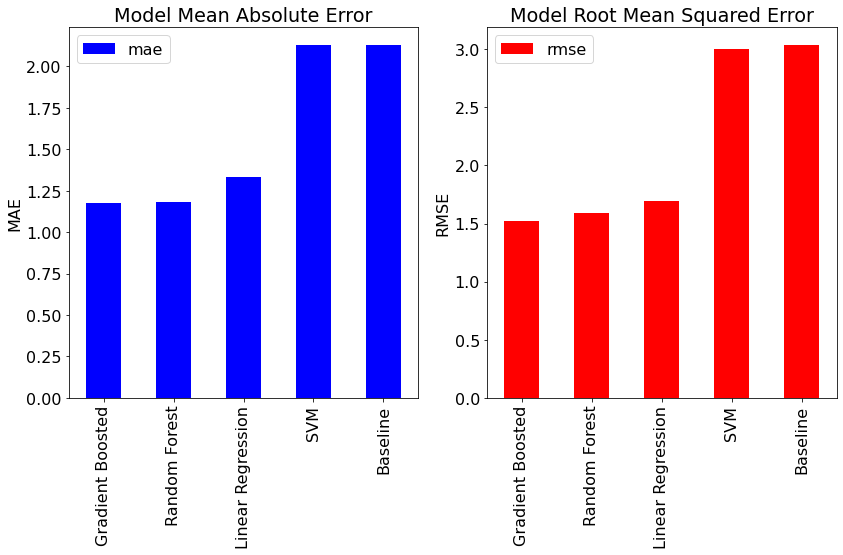

In [54]:
figsize(12, 8)
matplotlib.rcParams['font.size'] = 16
# Root mean squared error
ax =  plt.subplot(1, 2, 1)
results.sort_values('mae', ascending = True).plot.bar(y = 'mae', color = 'b', ax = ax)
plt.title('Model Mean Absolute Error'); plt.ylabel('MAE');

# Median absolute percentage error
ax = plt.subplot(1, 2, 2)
results.sort_values('rmse', ascending = True).plot.bar(y = 'rmse', color = 'r', ax = ax)
plt.title('Model Root Mean Squared Error'); plt.ylabel('RMSE');

plt.tight_layout()

In [55]:
results

,mae,rmse
Linear Regression,1.33532,1.69068
Random Forest,1.17924,1.59194
SVM,2.12682,3.00107
Gradient Boosted,1.17448,1.52242
Baseline,2.12973,3.03707


In [56]:
# Model for Bayesian Linear Regression 
model_blm = 'MagnM ~ ' + ' + '.join(['%s' % variable for variable in X_train.columns[1:]])
model_blm

'MagnM ~ Bmax + DV + Vmean + Bdo_Bup + Ndo_Nup'

In [57]:
print('The Gradient Boosted regressor is {:0.2f}% better than the baseline.'.format(
    (100 * abs(results.loc['Gradient Boosted', 'mae'] - results.loc['Baseline', 'mae'])) / results.loc['Baseline', 'mae']))

The Gradient Boosted regressor is 44.85% better than the baseline.


In [59]:
lr = LinearRegression()
lr.fit(X_train.drop(columns='MagnM'), y_train)

ols_formula = 'MagnM = %0.2f +' % lr.intercept_
for i, col in enumerate(X_train.columns[1:]):
    ols_formula += ' %0.2f * %s +' % (lr.coef_[i], col)
    
' '.join(ols_formula.split(' ')[:-1])

'MagnM = -2.43 + 0.19 * Bmax + 0.01 * DV + 0.00 * Vmean + 0.05 * Bdo_Bup + -0.46 * Ndo_Nup'

In [61]:
# Formula for Bayesian Linear Regression (follows R formula syntax
formula = 'MagnM ~ ' + ' + '.join(['%s' % variable for variable in X_train.columns[1:]])
formula

'MagnM ~ Bmax + DV + Vmean + Bdo_Bup + Ndo_Nup'

In [65]:
# Context for the model
with pm.Model() as normal_model:
    
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.Normal()
    
    # Creating the model requires a formula and data (and optionally a family)
    pm.GLM.from_formula(formula, data = X_train, family = family)
    
    # Perform Markov Chain Monte Carlo sampling
    normal_trace = pm.sample(draws=2000, chains = 2, tune = 500, cores=-1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, Ndo_Nup, Bdo_Bup, Vmean, DV, Bmax, Intercept]


Sampling 1 chain for 36 tune and 0 draw iterations (36 + 0 draws total) took 5 seconds.
No posterior samples. Unable to run convergence checks
